## Notebook used to fit a curve to radial velocity data

In [177]:
"""
Inital Imports
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.ticker as ticker
import mpld3
# mpld3.enable_notebook()

In [178]:
"""
Read in the data and convert to numpy
"""

data = pd.read_csv('wasp2b_radialvelocity.csv')
time_wasp = data['Obs_Date'].to_numpy()
time_wasp = time_wasp - 2450000
vel_wasp = data['Velocity'].to_numpy()
vel_err_wasp = data['Error'].to_numpy()

In [179]:
"""
Define Constants
"""

mass_sun = 1.989e30
radius_sun = 6.960e8
G = 6.67e-11
au = 1.496e11
alpha = np.power(G/(4*np.power(np.pi, 2)), (1/3))

wasp_mass = 0.79 * mass_sun
wasp_mass_err_pos = 0.15 * mass_sun
wasp_mass_err_neg = 0.04 * mass_sun

incl = 84.4
incl_err = 0.4

transit_time = 2453991.5146 - 2450000

guess_freq = 3
guess_amplitude = (np.max(vel_wasp) - np.mean(vel_wasp)) 
guess_phase = 0
guess_offset = np.mean(vel_wasp)
guess = [guess_freq, guess_amplitude, guess_phase, guess_offset]

In [180]:
def my_sin(x, freq, amplitude, phase, offset):
    
    return np.sin((x * freq) + phase) * amplitude + offset

In [181]:
def func_fitter(time, rad_vel, err, guess):

    # Initial guesses
    p0=[*guess]

    # now do the fit
    fit, pcov = curve_fit(my_sin, time, rad_vel, p0=p0, sigma=err, bounds=([0,-np.inf,0,-np.inf],[np.inf,np.inf,360,np.inf]))

    return fit, pcov

In [207]:
def chisquared(fit, time):
    """
    Function to return chi squared and reduced chi squared 
    """
    phase = fit[0]
    chisq = np.sum(np.power((vel_wasp - my_sin(time, *fit)), 2)/np.power(vel_err_wasp, 2))
    rchisq = chisq/(len(vel_wasp)-4)

    
    return chisq, rchisq

In [186]:
def radvelparams(fit, pcov):
    """
    Calculate and return Planetary Properties and their errors
    # params - [0]=freq, [1]=period_sec, [2]=star_vel, 
               [3]=semi_m_a, [4]=min_planet_mass, [5]=true_planet_mass
    

    # errors - [0]=freq_err, [1]=period_sec_err, [2]=star_vel_err, 
               [3]=semi_m_a_err_pos, [4]=semi_m_a_err_neg, [5]=min_planet_mass_err, 
               [6]=true_planet_mass_err
    """
    
    perr = np.sqrt(np.diag(pcov))
    
    freq = fit[0] / (2 * np.pi)
    freq_err = perr[0]
    freq_err1 = (perr[0] / fit[0]) * freq
    
    star_vel = fit[1] * 1e3
    star_vel_err = perr[1] * 1e3
    
    period_day = 1 / freq
    period_sec = period_day * 24 * 3600
    period_day_err = period_day * (perr[0] / fit[0])
    period_sec_err = period_day_err * 24 * 3600

    semi_m_a = np.power((G * np.power(period_sec, 2) * wasp_mass) / (4 * np.power(np.pi, 2)), 1/3)  
    semi_m_a_err1 = np.power(period_sec_err, 2) * np.power((2/3) * alpha * np.power(wasp_mass, (1/3)) * np.power(period_sec, (-1/3)), 2)
    semi_m_a_err2 = np.power(wasp_mass_err_pos, 2) * np.power((1/3) * alpha * np.power(wasp_mass, (-2/3)) * np.power(period_sec, (2/3)), 2)
    semi_m_a_err3 = np.power(wasp_mass_err_neg, 2) * np.power((1/3) * alpha * np.power(wasp_mass, (-2/3)) * np.power(period_sec, (2/3)), 2)
    semi_m_a_err_pos = np.sqrt(semi_m_a_err1 + semi_m_a_err2)
    semi_m_a_err_neg = np.sqrt(semi_m_a_err1 + semi_m_a_err3)

    min_planet_mass = (wasp_mass * star_vel * period_sec) / (2 * np.pi * semi_m_a)
    min_planet_mass_err_1 = np.power((wasp_mass_err_pos), 2) * np.power((star_vel * period_sec) / (2 * np.pi * semi_m_a), 2)
    min_planet_mass_err_2 = np.power((perr[1]), 2) * np.power((wasp_mass * period_sec) / (2 * np.pi * semi_m_a), 2)
    min_planet_mass_err_3 = np.power(period_sec_err, 2) * np.power((wasp_mass * star_vel) / (2 * np.pi * semi_m_a), 2)
    min_planet_mass_err_4 = np.power(semi_m_a_err_pos, 2) * np.power((wasp_mass * star_vel * period_sec) / (2 * np.pi * np.power(semi_m_a, 2)), 2)
    min_planet_mass_err = np.sqrt(min_planet_mass_err_1 + min_planet_mass_err_2 + min_planet_mass_err_3 + min_planet_mass_err_4)            
    
    true_planet_mass = min_planet_mass / np.sin(incl * (np.pi/180))
    true_planet_mass_err = np.sqrt(np.power(incl_err, 2) * np.power((min_planet_mass * (1/np.tan(incl*(np.pi/180)))*(1/np.sin(incl*(np.pi/180)))), 2))
    
    
    params = np.array([freq, period_sec, star_vel, semi_m_a, min_planet_mass, true_planet_mass])
    errors = np.array([freq_err, period_sec_err, star_vel, semi_m_a_err_pos, semi_m_a_err_neg, min_planet_mass_err, true_planet_mass_err])
    
    
    return params, errors

In [187]:
"""
Plotting the Radial Velocity Curve Fit and the Photometric Curve Fit
"""

def plotting(xdata1, xdata2, ydata1, ydata2):
    plt.rcParams["font.family"] = "serif"
    fig, (ax1, ax2) = plt.subplots(2, sharex=False)

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major', direction='in', length=6, width=2, colors='black', top=True, right=True)
    ax1.tick_params(which='minor', direction='in', length=4, top=True, right=True)

    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.tick_params(which='major', direction='in', length=6, width=2, colors='black', top=True, right=True)
    ax2.tick_params(which='minor', direction='in', length=4, top=True, right=True)

    fig.suptitle('WASP-2: Radial Velocity Curve Fit')
    ax1.errorbar(time_wasp, vel_wasp, yerr=vel_err_wasp, fmt='o', ms=7.5, label='Radial Velocity Data', ecolor='k', marker='x', mew=1.5)
    ax1.plot(xdata1, ydata1, label='Fitted Curve', color='darkorange')
    ax1.set_xlabel(r"Barycentric JD$ - 2450000.0$")
    ax1.set_ylabel(r"Radial Velocity " +'\n' r"$[kms^{-1}]$")

    ax2.errorbar(photophase, vel_wasp, yerr=vel_err_wasp, fmt='o', ms=7.5, label='Radial Velocity Data', ecolor='k', marker='x', mew=1.5)
    ax2.plot(xdata2, ydata2, label='Fitted Curve', color='darkorange')
    ax2.set_xlabel("Photometric Phase")
    ax2.set_ylabel(r"Radial Velocity " + '\n' r"$[kms^{-1}]$")
    fig.tight_layout()
    # plt.savefig('rad_vel_fit_phase.png')
    plt.show()

In [202]:
"""
Plotting the Residuals of the Radial Velocity Curve Fit
"""

def plotting_residuals(xdata1, xdata2, ydata1, ydata2):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major', direction='in', length=6, width=2, colors='black', top=True, right=True)
    ax1.tick_params(which='minor', direction='in', length=4, top=True, right=True)

    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.tick_params(which='major', direction='in', length=6, width=2, colors='black', top=True, right=True)
    ax2.tick_params(which='minor', direction='in', length=4, top=True, right=True)

    fig.suptitle('WASP-2: Radial Velocity Curve Fit Residuals')
    ax1.errorbar(xdata1, ydata1, yerr=vel_err_wasp, fmt='o', ms=7.5, ecolor='k', marker='x', mew=1.5)
    ax1.axhline(y=0, color='darkorange')
    ax1.set_ylabel("Radial Velocity" +'\n' "Residuals")

    ax2.errorbar(xdata2, ydata2, yerr=new_y_err, fmt='o', ms=7.5, ecolor='k', marker='x', mew=1.5)
    ax2.axhline(y=0, color='darkorange')
    ax2.set_xlabel(r"Barycentric JD$ - 2450000.0$")
    ax2.set_ylabel("Radial Velocity" +'\n' "Residuals")

    fig.tight_layout()
#     plt.savefig('RV_residuals.png')
    plt.show()

In [199]:
"""
Fitting the data and the photophase plot
"""

fit1, pcov1 = func_fitter(time_wasp, vel_wasp, vel_err_wasp, guess)
fitx1 = np.linspace(time_wasp[0]-0.5, time_wasp[-1]+0.75, 10000) 
fity1 = my_sin(fitx1, *fit)

params1, errors1 = radvelparams(fit, pcov)

photophase = ((time_wasp - transit_time/2) % (params1[1]/(24*3600))) - (params1[1]/(24*3600))/2

fit2, pcov2 = func_fitter(photophase, vel_wasp, vel_err_wasp, guess)
fitx2 = np.linspace(-1.5, 1.5, 10000) 
fity2 = my_sin(fitx2, *fit2)

params2, errors2 = radvelparams(fit2, pcov2)

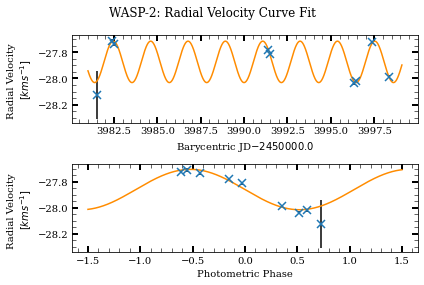

In [200]:
"""
Plot the fitted curve for raw data and photometric phase plot
"""
plotting(fitx1, fitx2, fity1, fity2)

In [208]:
chi1, rchi1 = chisquared(fit1, time_wasp)
chi2, rchi2 = chisquared(fit2, photophase)
print(f"The reduced chi squared value for the original fit is: {rchi1}")
print(f"The reduced chi squared value for the photophase fit is: {rchi2}")

The reduced chi squared value for the original fit is: 1.5433422548104576
The reduced chi squared value for the photophase fit is: 4.4633400448587635


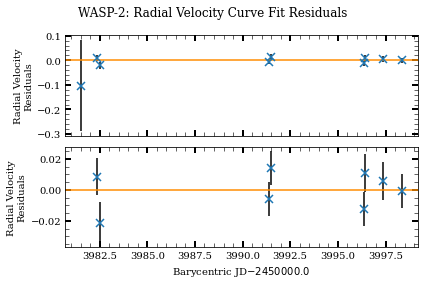

In [205]:
residuals = vel_wasp - my_sin(time_wasp, *fit1)
new_x = np.delete(time_wasp, [0])
new_y = np.delete(residuals, [0])
new_y_err = np.delete(vel_err_wasp, [0])

plotting_residuals(time_wasp, new_x, residuals, new_y)